In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import umap

import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_digits, fetch_openml, load_breast_cancer

from scipy.spatial.distance import pdist

# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

import lib.baseline as baseline
import lib.util as util
from lib.baycon import baycon_explainer

from lib.eval.eval_metrics import *
from lib.dice_mod import Gainer, random_opt, gradient_ascent

%load_ext autoreload
%autoreload 2

2025-03-31 01:04:38.223562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
def plot_heatmap(X, y, C, random_point, fn, target_cluster, use_pca=False, solutions=None, histories=None):

    dim_ranges = np.abs(np.max(X, axis=0) - np.min(X, axis=0))
    samples = []
    for _ in range(1):
        sample = np.random.rand(1, X.shape[1]) * dim_ranges + np.min(X, axis=0)
        samples.append(sample)
    samples = np.array(samples).reshape(-1, X.shape[1])
    sample_gains = np.array([fn(point.reshape(1, -1)) for point in samples])
    best_samples = samples[np.argsort(-sample_gains)[:10]]
    bs = best_samples.copy()

    if use_pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        C = pca.transform(C)
        best_samples = pca.transform(best_samples)
        random_point = pca.transform(random_point)
        if solutions is not None:
            solutions = [pca.transform(solution) for solution in solutions]
        if histories is not None:
            histories = [pca.transform(history) for history in histories]
    
    plt.figure(figsize=(10, 8))

    # Create a grid for the heatmap
    if not use_pca:
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                            np.linspace(y_min, y_max, 100))
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        values = np.array([fn(point.reshape(1, -1)) for point in grid_points])
        grid = values.reshape(xx.shape)
        plt.contourf(xx, yy, grid, levels=50, cmap='viridis', alpha=0.5)
        plt.colorbar(label='value')


    # values = np.array([fn(point.reshape(1, -1)) for point in samples])

    # Plot data points, cluster centers, and random point
    unique_labels = np.unique(y)
    palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette

    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette)
    sns.scatterplot(x=C[:, 0], y=C[:, 1], color='red', s=100, marker='o')
    sns.scatterplot(x=random_point[:, 0], y=random_point[:, 1], color='green', s=100, marker='o')
    # sns.scatterplot(x=best_samples[:, 0], y=best_samples[:, 1], color='blue', s=50, marker='x')
    if histories is not None:
        for h in histories:
            plt.plot(h[:, 0], h[:, 1], color='black', linewidth=1, linestyle='dashed', markersize=2)
    if solutions is not None:
        for s in solutions:
            sns.scatterplot(x=s[:, 0], y=s[:, 1], color='purple', s=100, marker='o')

    plt.title(f'Heatmap of values for target cluster {target_cluster} ({fn.__name__})')
    # plt.axis('equal')
    plt.show()
    return bs

5.655191906616356


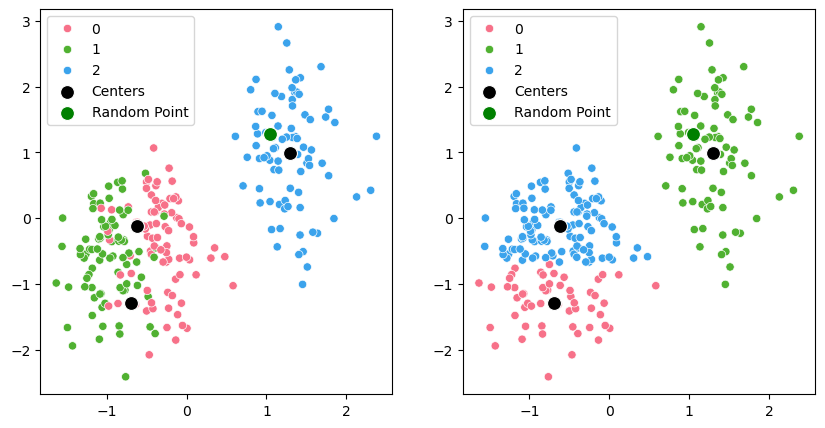

In [41]:
k = 3

X, y = make_blobs(centers=k, cluster_std=2, n_features=2, n_samples=250)
# X, y = load_breast_cancer(return_X_y=True)
# X, y = load_iris(return_X_y=True)
X = StandardScaler().fit_transform(X)
# X = X / np.max(pdist(X))
print(np.max(pdist(X)))
# normalize to max 1 dist
km = KMeans(n_clusters=k)
yy = km.fit_predict(X)
C = km.cluster_centers_

# random point from X:
random_point = X[[np.random.randint(0, X.shape[0])]]


def plot(X, y, C, x, pca=False, use_umap=False):
    assert not (pca and use_umap)
    if use_umap:
        reducer = umap.UMAP()
        X = reducer.fit_transform(X)
        C = reducer.transform(C)
        x = reducer.transform(x)
    if pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        C = pca.transform(C)
        x = pca.transform(x)
    unique_labels = np.unique(y)
    palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette

    _fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for ax, h in zip(axs, [y, yy]):
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=h, palette=palette, legend="full", ax=ax)
        sns.scatterplot(x=C[:, 0], y=C[:, 1], color='black', s=100, marker='o', label='Centers', ax=ax)
        sns.scatterplot(x=x[:, 0], y=x[:, 1], color='green', s=100, marker='o', label='Random Point', ax=ax)
    plt.show()

plot(X, y, C, random_point, pca=False, use_umap=False)

X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 2, score: 8.748179073128205e-06, imp: 3.2349957606031267e-08, grad: 8.104405016212843e-05
iter: 3, score: 8.78022469279496e-06, imp: 3.204561966675497e-08, grad: 7.998289695332091e-05
iter: 4, score: 8.812508769456004e-06, imp: 3.228407666104477e-08, grad: 8.027964912897454e-05
iter: 5, score: 8.84503398477024e-06, imp: 3.2525215314235453e-08, grad: 8.05786240388096e-05
iter: 6, score: 8.877803060818665e-06, imp: 3.276907604842485e-08, grad: 8.087984677763851e-05
iter: 7, score: 8.91081876086959e-06, imp: 3.3015700050925453e-08, grad: 8.118334281953429e-05
iter: 8, score: 8.944083890160724e-06, imp: 3.32651292911339e-08, grad: 8.148913802502405e-05
iter: 9, score: 8.977601296700037e-06, imp: 3.351740653931309e-08, grad: 8.179725864844097e-05
iter: 10, score: 9.011373872084127e-06, imp: 3.37725753840902e-08, grad: 8.210773134545335e-05
iter: 11, score: 9.045404552336074e-06, imp: 3.4030680251946906e-08, grad: 8.242058318075838e-05
iter: 12, score: 9

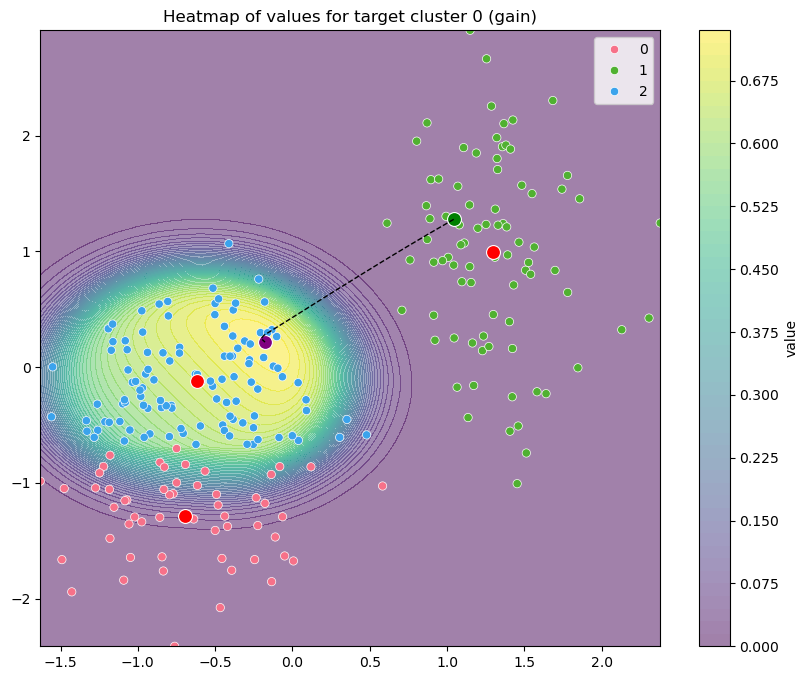

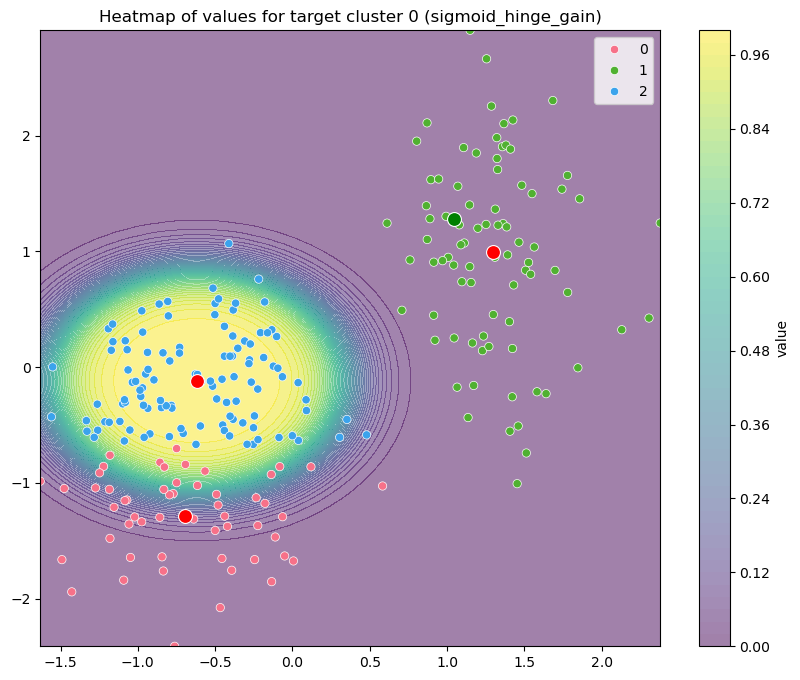

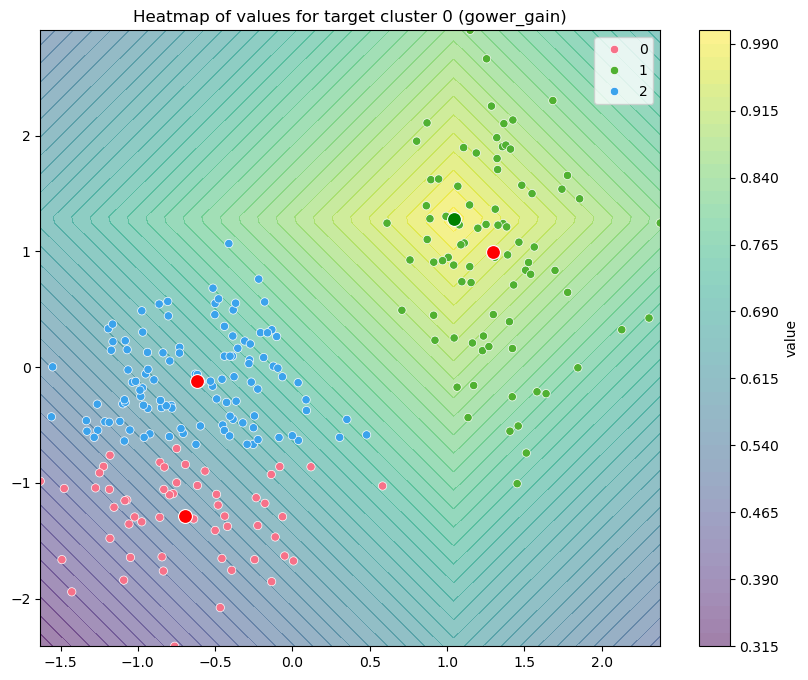

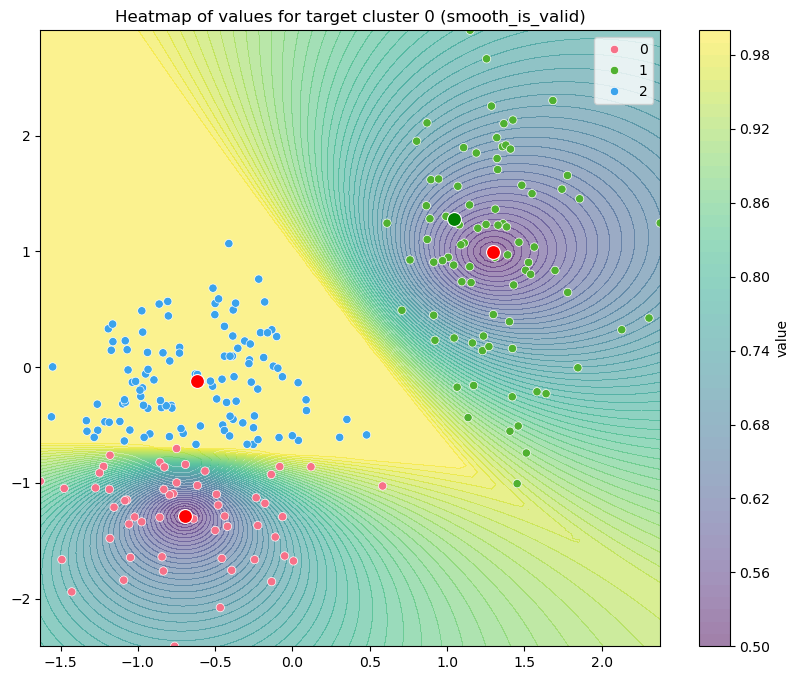

In [54]:
# Example usage
l = Gainer(C, X, 2, random_point, eps=0.2)

sols = []
hists = []
for i in range(1):
    sol, hist = gradient_ascent(random_point, l.gain, dbg=True, lr=5)
    sols.append(sol)
    hists.append(hist)
print(f"solution predictions: {[int(km.predict(s.reshape(1, -1))[0]) for s in sols]}")

best = plot_heatmap(
    X, yy, C, random_point, l.gain, target_cluster=0, 
    use_pca=False, 
    solutions=sols, 
    histories=hists
)
# print(best[0].reshape(1, -1).shape)

# valid = np.array([l.is_valid(point.reshape(1,-1)) for point in best])
# sparsity = np.array([l.sparsity_gain(point) for point in best])
# df = pd.DataFrame()
# df['valid'] = valid
# df['sparsity'] = sparsity
# print(df)

for lt in l.gain_weights.keys():
    sols = []
    hists = []
    for i in range(0):
        sol, hist = random_opt(random_point, lt)
        sols.append(sol)
        hists.append(hist)
    plot_heatmap(X, yy, C, random_point, lt, target_cluster=0, use_pca=False, solutions=sols)

In [7]:
def load_mnist_clustering():
    X, target = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    # mdist = np.max(pdist(X))
    mdist = 4303.319300261137
    X = X / mdist
    # X = StandardScaler().fit_transform(X)

    X = X.astype(np.float64)
    target = target.astype(int)

    km = KMeans(n_clusters=10)
    y = km.fit_predict(X)
    C = km.cluster_centers_
    return X, y, C, target, km

X, y, C, target, km = load_mnist_clustering()

(70000, 784)
real label: 3
cluster label: 7
[3 6 5 ... 8 8 0]
[5 0 4 ... 4 5 6]


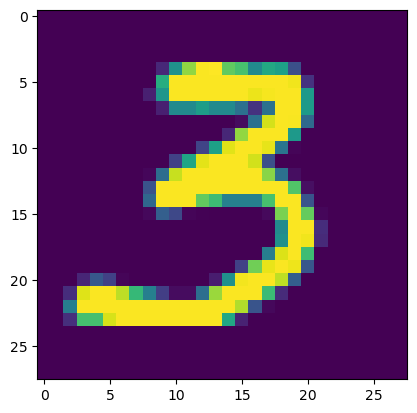

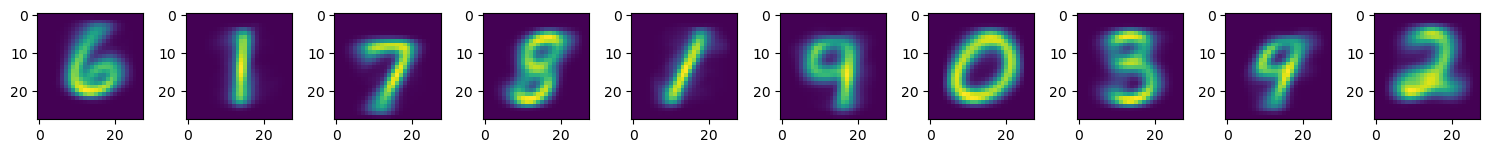

In [8]:
print(X.shape)
idx = 975
random_point = X[idx].reshape(1, -1)
real_lbl = target[idx]
cluster_lbl = y[idx]

def showim(x, ax = None):
    if ax is not None:
        ax.imshow(x[0].reshape(28, 28))
        return
    plt.imshow(x[0].reshape(28, 28))
    plt.show()
print(f"real label: {real_lbl}")
print(f"cluster label: {cluster_lbl}")
print(y)
print(target)
showim(random_point)

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, c in enumerate(C):
    showim(c.reshape(1, -1), ax=axes[i])
plt.tight_layout()
plt.show()


X: (70000, 784)
C: (10, 784)
x: (1, 784)
iter: 201, score: 0.8837040556089435
iter: 201, score: 0.868919955840724
iter: 201, score: 0.8479815901066362
iter: 201, score: 0.8248909673926037
iter: 201, score: 0.8001196021555818
iter: 201, score: 0.7725553570682976
iter: 201, score: 0.7365981503449833
iter: 1000, score: 0.6827551715299973
iter: 186, score: 0.620134964795294
iter: 275, score: 0.523004422657375
iter: 228, score: 0.3981667188717504


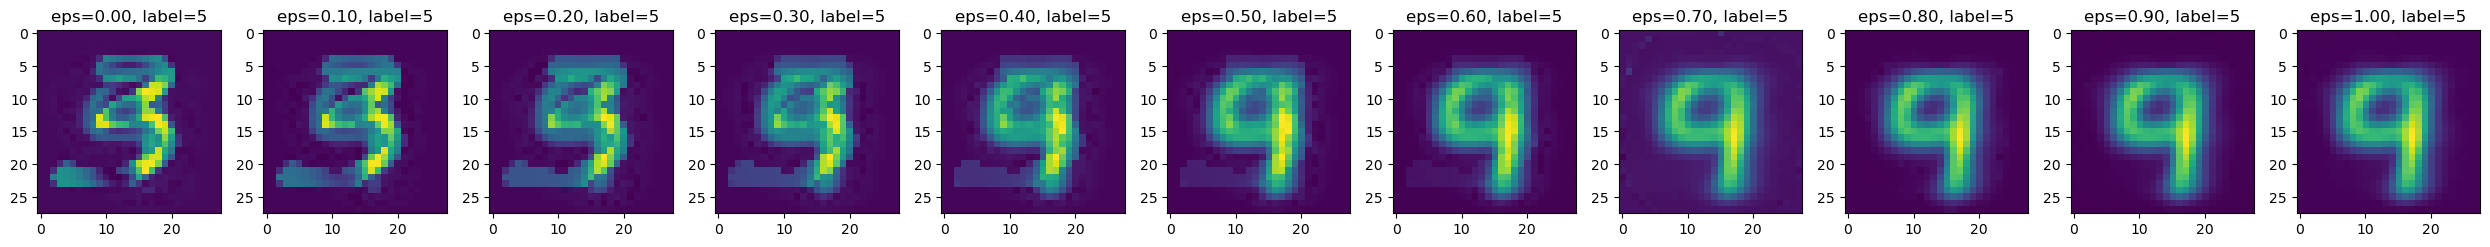

In [12]:
fig, axes = plt.subplots(1, 11, figsize=(25, 5))
l = Gainer(C, X, 5, random_point)
for i,e in enumerate(np.linspace(0,1,11)):
    l.eps = e
    sol, _hist = gradient_ascent(random_point, l.gain, dbg=False)
    showim(sol, ax=axes[i])
    axes[i].set_title(f"eps={e:.2f}, label={km.predict(sol)[0]}")
plt.tight_layout()
plt.show()

In [ ]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

/nix/store/qjgmb81jx90lj7c6xxrkq8i5h8rgjn7g-python3.12-scikit-learn-1.6.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nix/store/7l3hfdx2idiwj44jy73b5x03hksbnzks-python3.12-umap-learn-0.5.7/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(70000, 2)


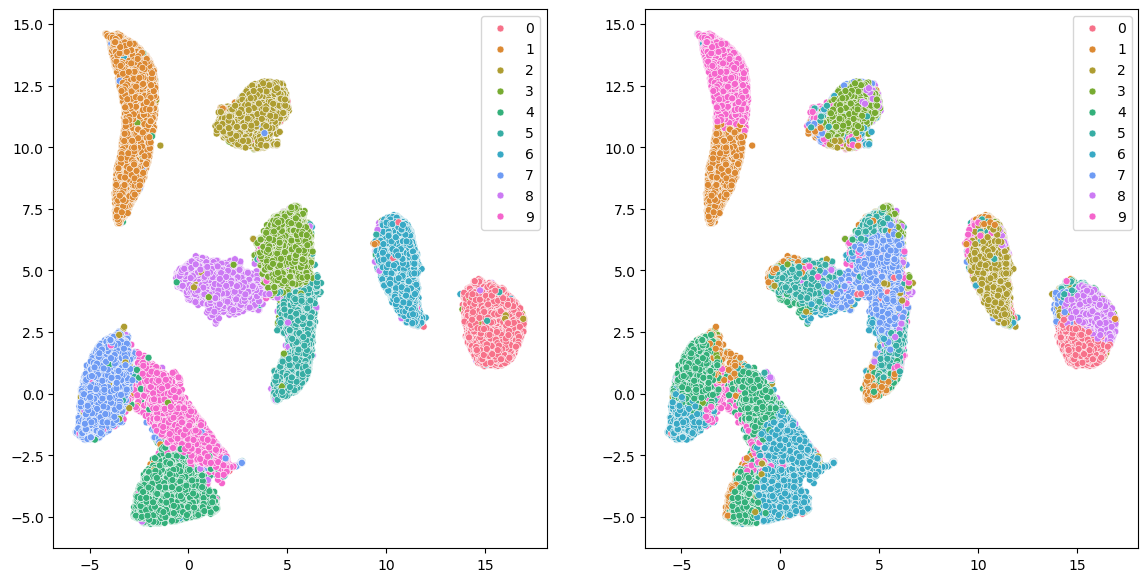

In [ ]:
print(X_umap.shape)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

palette = sns.color_palette("husl", len(np.unique(target)))  # Use a distinct color palette
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=target, palette=palette, legend='full', ax=axes[0], s=25)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette=palette, legend='full', ax=axes[1], s=25)
plt.legend()
plt.show()